### Let us install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) I have selected the pytorch interface because it strikes a nice balance between the high-level APIs and tensorflow code .

In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
import time
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
data = pd.read_csv("data.csv", sep = ';', encoding = 'latin1', names = ["sentence", "label"])

In [5]:
data.head()

,sentence,label
0,"Our friends won't buy this analysis, let alone...",1
1,One more pseudo generalization and I'm giving up.,1
2,One more pseudo generalization or I'm giving up.,1
3,"The more we study verbs, the crazier they get.",1
4,Day by day the facts are getting murkier.,1


###Data preparation for BERT

In [6]:
# Create sentence and label lists
sentences = data.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = data.label.values

In [7]:
sentences[:3]

["[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]",
 "[CLS] One more pseudo generalization and I'm giving up. [SEP]",
 "[CLS] One more pseudo generalization or I'm giving up. [SEP]"]

###Import the BERT **Tokenizer**, used to convert our **text** into **tokens** that correspond to BERT's vocabulary.

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

100%|██████████| 231508/231508 [00:00<00:00, 1306606.31B/s]


In [9]:
print("An example of tokenized  sentence: \n", tokenized_texts[0])

An example of tokenized  sentence: 
 ['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


##Data configuration for BERT

###To accommodate BERT's requirement for **fixed-size input arrays**, I opted to set a **maximum sentence length**. Hence, I padded or truncated my inputs  to ensure that each input sequence matches this predetermined length.

*   ### To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add zeros to the end of the sequence until it is the maximum sentence length.
*   ### If a sentence is longer than the maximum sentence length, then we simply **truncate** the end of the sequence, discarding anything that does not fit into our maximum sentence length.










In [10]:
maximum_length = 228

In [11]:
# Using the BERT tokenizer, to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
#print("Id of every word in a tokenized sentence: \n", input_ids[0])
input_ids[0]

[101,
 2256,
 2814,
 2180,
 1005,
 1056,
 4965,
 2023,
 4106,
 1010,
 2292,
 2894,
 1996,
 2279,
 2028,
 2057,
 16599,
 1012,
 102]

In [12]:
# Pad the input tokens
input_ids = pad_sequences(input_ids, maxlen=maximum_length, dtype="long", truncating="post", padding="post")
input_ids[0]

array([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,
        1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [13]:
input_ids.shape

(8551, 228)

In [14]:
len(input_ids)

8551

In [15]:
len(labels)

8551

In [16]:
len(np.array(labels))

8551

In [17]:
input_ids_array = np.array(input_ids)
labels_array = np.array(labels)

#smote = SMOTE(random_state=42)
#input_ids_resampled, labels_resampled = smote.fit_resample(input_ids_array, labels_array)  # SMOTE oversampling

undersampler = RandomUnderSampler(random_state=42)
input_ids_undersampled, labels_undersampled = undersampler.fit_resample(input_ids_array, labels_array)

# Check the class distribution after oversampling
unique, counts = np.unique(labels_undersampled, return_counts=True)
print("Class Distribution after Oversampling:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

Class Distribution after Oversampling:
Label 0: 2528
Label 1: 2528


In [18]:
print((len(input_ids_undersampled), len(labels_undersampled)))

(5056, 5056)


In [19]:
print((input_ids_undersampled.shape, labels_undersampled.shape))

((5056, 228), (5056,))


In [20]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for sequence in input_ids_undersampled:
  sequence_mask = [float(i>0) for i in sequence] # 1 if "i" it's an input_id and 0 if padding sequence
  attention_masks.append(sequence_mask)

### Training and validation sets

In [21]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids_undersampled, labels_undersampled,
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids_undersampled,
                                             random_state=2018, test_size=0.2)

In [22]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
#For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32

batch_size = 16 # for simplicity reasons

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because,
# unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Creaton of the model

#### BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top

In [24]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)  # base model for lowercase tokens
model.cuda()

100%|██████████| 407873900/407873900 [00:13<00:00, 29777420.31B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [25]:
# total parameters of the large model
total_params = sum(p.numel() for p in model.parameters())
print("Total Parameters:", total_params)

Total Parameters: 109483778


In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [27]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

##Training & Validation phases

In [28]:
start_time = time.time()


model.to(device)

# Function to calculate metrics
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, pred_flat)

def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, pred_flat)


train_loss_set = []     # Store our loss
learning_rate = 2e-5
epochs = 4

train_accuracy_set = []
train_precision_set = []        # Store training metrics for plotting
train_recall_set = []

val_accuracy_set = []
val_precision_set = []        # store validation metrics for plotting
val_recall_set = []

for _ in trange(epochs, desc="Epoch"):
    ## TRAINING PHASE ##
    # Set our model to training mode
    model.train()
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    ## VALIDATION PHASE ##
    # Put model in evaluation mode
    model.eval()
    # Tracking variables
    eval_loss, eval_accuracy, eval_precision, eval_recall = 0, 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        tmp_eval_precision = flat_precision(logits, label_ids)
        tmp_eval_recall = flat_recall(logits, label_ids)
        # Accumulate the total accuracy
        eval_accuracy += tmp_eval_accuracy
        eval_precision += tmp_eval_precision
        eval_recall += tmp_eval_recall
        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print("Validation Precision: {}".format(eval_precision/nb_eval_steps))
    print("Validation Recall: {}".format(eval_recall/nb_eval_steps))

    # Append metrics for plotting
    train_accuracy_set.append(eval_accuracy/nb_eval_steps)
    train_precision_set.append(eval_precision/nb_eval_steps)
    train_recall_set.append(eval_recall/nb_eval_steps)


end_time = time.time()

print("The training and validation phases took about : ", (end_time-start_time)//60, "minutes" )

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6489905163704642


Epoch:  25%|██▌       | 1/4 [03:19<09:59, 199.68s/it]

Validation Accuracy: 0.744140625
Validation Precision: 0.7222791531385281
Validation Recall: 0.7789575441919192
Train loss: 0.3870396134351553


Epoch:  50%|█████     | 2/4 [06:44<06:44, 202.43s/it]

Validation Accuracy: 0.75
Validation Precision: 0.6828832192113442
Validation Recall: 0.8964798656204905
Train loss: 0.16130213389033268


Epoch:  75%|███████▌  | 3/4 [10:10<03:24, 204.08s/it]

Validation Accuracy: 0.763671875
Validation Precision: 0.7117308906371403
Validation Recall: 0.895038555194805
Train loss: 0.07320698436161893


Epoch: 100%|██████████| 4/4 [13:34<00:00, 203.61s/it]

Validation Accuracy: 0.7705078125
Validation Precision: 0.7438577915140414
Validation Recall: 0.8340993641774889
The training and validation phases took about :  13.0 minutes


### The training and validation phases took about 13 minutes to complete

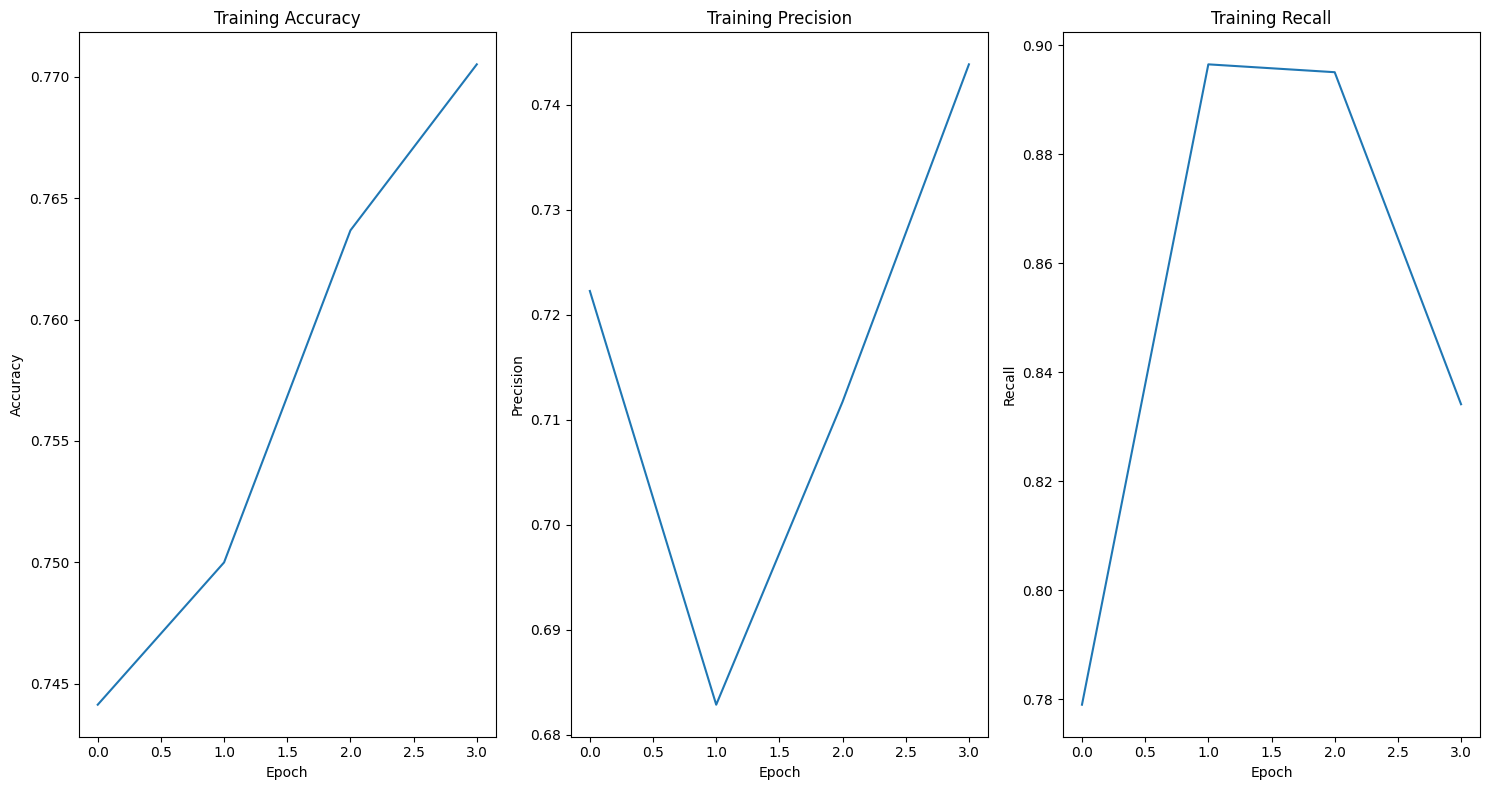

In [29]:
# Plotting accuracy, precision, and recall evolution
plt.figure(figsize=(15,8))

plt.subplot(1, 3, 1)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy_set)

plt.subplot(1, 3, 2)
plt.title("Training Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.plot(train_precision_set)

plt.subplot(1, 3, 3)
plt.title("Training Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.plot(train_recall_set)

plt.tight_layout()
plt.show()


###The graphs suggest that we can use the early stopping method, since accuracy and recall are getting much more higher after epoch 3, although recall decreases.

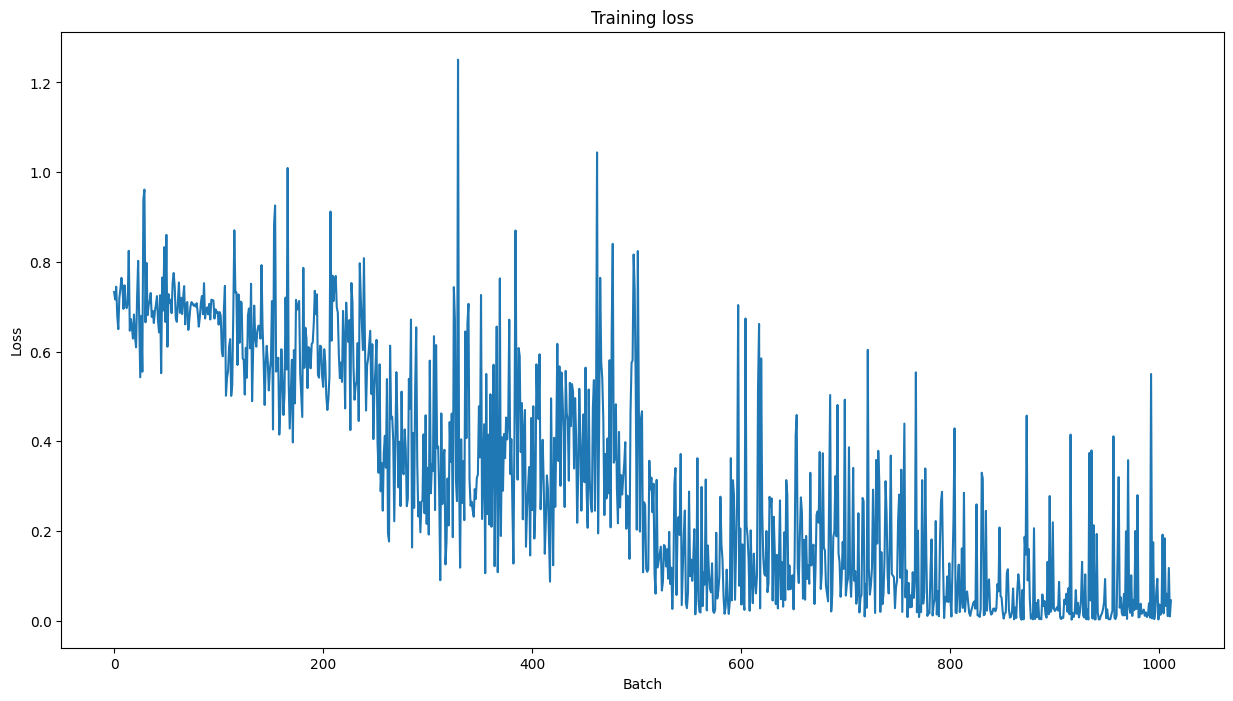

In [30]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

###Training loss is much higher than the two cases when we had imbalanced dataset and overampling method. As for our actual loss. It's equal to 0.07, and for the case of imbalanced dataset, we get 0.062 and 0.042 for the case of applying oversampling method. Hence we decreased the loss by 2% compared to the imbalanced dataset and by 3% as compared to the application of undersampling technique.